# 2. Diabetes Prediction with MLP

## 2.1 Basic Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# keras와 sklearn은 나중에 따로 임포트

## 2.2 Business Understanding

당뇨병은 신체 혈당 수치가 상승해 나타나는 만성 질환이며, 심혈관 질환과 뇌졸증, 신장 손상, 신체 말단 손상을 초래함.

전 세계 약 4억명 이상이 당뇨병을 앓고 있으며, 매년 최대 500만명이 당뇨 관련 합병증으로 사망한다.

인슐린 생산 부족으로 인한 제1형 당뇨는 예방하기 어렵고 치료하기도 어렵지만, 인슐린 저항 때문에 생기는 제2형 당뇨는 예방이 가능하다.

제2형 당뇨는 과체중, 운동 부족, 잘못된 식습관 등이 주요 원인이다. 그러나 초기에는 별 증상이 없어 예측이 매우 어려운 실정이다.

이러한 문제를 머신러닝을 통해서 예측해보자.

## 2.4 Dataset

Pima Indians 당뇨 데이터셋이며, 미국 국립보건원 산하의 당뇨 소화 신장 질병 센터가 제공하고 케글을 통해 공개하였다.

https://www.kaggle.com/uciml/pima-indians-diabetes-database

## 2.5 EDA

In [42]:
df = pd.read_csv("diabetes.csv")
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Columns Describtion

- Pregnancies : 과거 임신 횟수
- Glucose : 혈장 혈당
- BloodPressure : 이완기 혈압
- SkinThickness : 삼두근에서 측정한 피부두겹두께
- Insulin : 혈청 인슐린 농도
- BMI : 체질량 지수
- DiabetesPedigreeFunction : 환자의 당뇨 가족력을 바탕으로 당뇨 취약 요약 점수
- Age : 나이
- Outcome : 예측 변수, 최초 측정 이후 5년 내 당뇨가 발병하면 값이 1

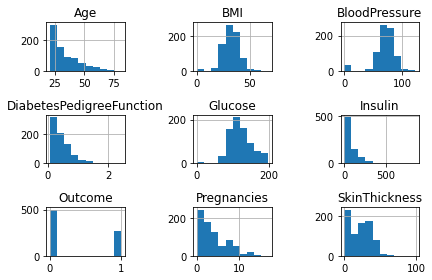

In [43]:
# 각 변수의 분포표를 살펴보자.

df.hist()
plt.tight_layout()
plt.show()

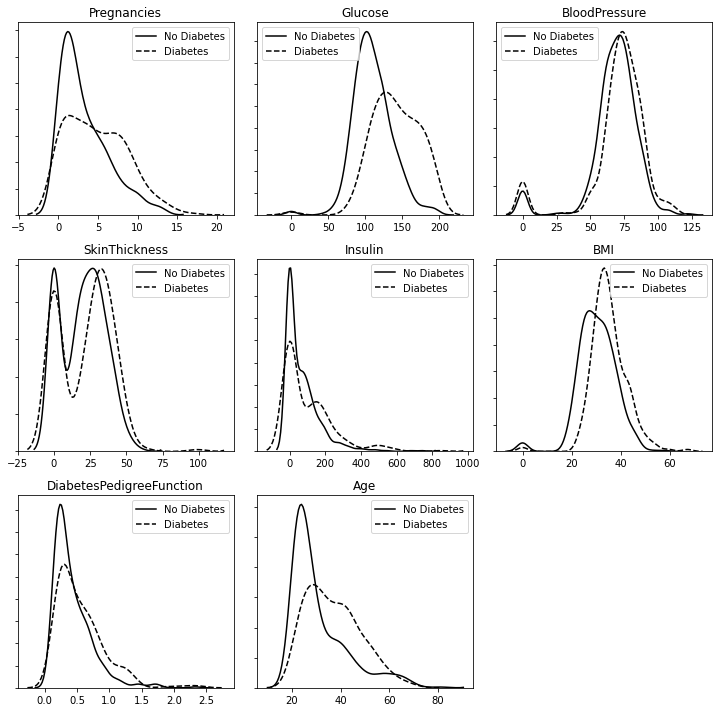

In [44]:
# 각 변수의 밀도표를 살펴보자.

plt.subplots(3,3,figsize=(10,10))

for idx, col in enumerate(df.columns[:-1]):
    ax = plt.subplot(3,3, idx+1)
    ax.yaxis.set_ticklabels([])
    sns.distplot(df.loc[df.Outcome ==0][col], hist=False, axlabel=False,
                kde_kws={'linestyle':'-', 'color':'black', 'label':"No Diabetes"})
    sns.distplot(df.loc[df.Outcome ==1][col], hist=False, axlabel=False,
                kde_kws={'linestyle':'--', 'color':'black', 'label':"Diabetes"})
    ax.set_title(col)
    
plt.subplot(3,3,9).set_visible(False)
plt.tight_layout()
plt.show()

## 2.6 Preprocessing

### 2.6.1 Missing Values

In [45]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


일부 column에서 최소값이 0이 발견되는데, 0이 애초에 나올 수 없는 column들이 있다.(혈압이라든지..)

즉 0 자체가 결측값이라고 볼 수 있으므로 전처리 해주겠다.

In [46]:
# 일단 0이 몇개씩이나 있는지 살펴보자.

for col in df.columns:
    zero = df.loc[df[col]==0].shape[0]
    print(col + ": " +str(zero))

Pregnancies: 111
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 500


In [47]:
# 0을 NaN으로 바꿔서 판다스가 결측값을 인식하게 만든다.
zero_col = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in zero_col:
    df[col] = df[col].replace(0, np.nan)

In [48]:
# 다시 0이 몇개인지 확인합니다.

for col in df.columns:
    zero = df.loc[df[col]==0].shape[0]
    print(col + ": " +str(zero))

Pregnancies: 111
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 500


In [49]:
# 이제 각 칼럼의 평균값으로 결측치를 대체합니다.

for col in zero_col:
    df[col] = df[col].fillna(df[col].mean())

In [50]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 2.6.2 Scaling

이 부분은 책과는 다릅니다.

In [51]:
# 변수 간의 범위가 너무 크면 모델에 영향력이 다르게 간다.
# 따라서 수치형 변수들을 스케일링 해주는 것이 중요하다.

# 개인적으로 좋아하는 표준화 식은 10배수 MinMaxScaler 다.

def tenMinMaxScaler(df, columns):
    for col in columns:
        col_min = df[col].min()
        col_max = df[col].max()
        df[col] = df[col].apply(lambda x: 10 * (x-col_min) / (col_max - col_min))
    return df

In [52]:
df.columns # columns 리스트 나열

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [53]:
# Outcome 만 빼고 columns 리스트로 선언
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

# 함수로 돌려줍니다.
df = tenMinMaxScaler(df, columns)

In [54]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,3.529412,6.709677,4.897959,3.043478,1.701301,3.149284,2.344150,4.833333,1
1,0.588235,2.645161,4.285714,2.391304,1.701301,1.717791,1.165670,1.666667,0
2,4.705882,8.967742,4.081633,2.407980,1.701301,1.042945,2.536294,1.833333,1
3,0.588235,2.903226,4.285714,1.739130,0.961538,2.024540,0.380017,0.000000,0
4,0.000000,6.000000,1.632653,3.043478,1.850962,5.092025,9.436379,2.000000,1


In [55]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,2.261795,5.012049,4.939305,2.407980,1.701301,2.915637,1.681795,2.040148,0.348958
std,1.982105,1.963610,1.234321,0.955537,1.021888,1.405961,1.414725,1.960039,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.588235,3.596774,4.081633,1.956522,1.292067,1.901840,0.707728,0.500000,0.000000
50%,1.764706,4.709677,4.918632,2.407980,1.701301,2.903885,1.257472,1.333333,0.000000
75%,3.529412,6.209677,5.714286,2.717391,1.701301,3.762781,2.340948,3.333333,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


### 2.6.3 Split Dataset

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
# 독립변수들로만 구성된 x와 라벨값인 y를 만들어줍니다.

x = df.loc[:, df.columns !='Outcome']
y = df.loc[:, 'Outcome']

In [58]:
# 테스트 셋과 트래인 셋을 나눕니다.

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [59]:
# 테스트 셋에서 검증 셋으로 또 나눕니다.

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((491, 8), (123, 8), (491,), (123,))

## 2.7 MLP

#### 히든 레이어는 2개로 하겠다. 활성함수는 ReLU와 Sigmoid를 쓰겠다.

## 2.8 Modeling with Keras

### 2.8.1 Model Organizing

In [60]:
# 먼저 케라스의 Sequential 클래스를 통해 골격을 만들어준다.

from keras.models import Sequential

In [61]:
model = Sequential()

In [62]:
# 첫 번째 은닉 레이어를 쌓는다. 노드는 32개, 입력 차원은 8개다.
# 노드는 임의로 정한 것이고, 입력 차원은 변수가 8개라 8개.
# 이어지는 다른 은닉 레이어의 크기는 케라스가 자동으로 계산한다.

from keras.layers import Dense

In [63]:
# 첫 번째 은닉 레이어 추가.
model.add(Dense(32, activation='relu', input_dim=8))
# 두 번째 은닉 레이어 추가.
model.add(Dense(16, activation='relu'))
# 마지막으로 출력 레이어 추가. 출력 레이어는 이진분류 결과를 출력하므로 노드는 1개, 출력값을 0과 1로 압축하는 시그모이드 사용
model.add(Dense(1, activation='sigmoid'))

### 2.8.2 Model Compile

모델을 훈련시키기 전에 훈련 과정에 필요한 매개변수를 정의한다.

훈련 매개변수는 compile 메서드에 전달하며, MLP의 훈련과정에 필요한 매개변수는 다음과 같다.

- Optimizer(옵티마이저) : adam옵티마이저 사용.
- Loss Function(손실 함수) : 이진 분류 문제이므로 binary_crossentropy 사용
- Metrics(평가 지표) : accuracy 사용

In [64]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 2.8.3 Model Training

In [65]:
# fit 함수를 통해 훈련시킨다. epochs 는 동일한 데이터를 몇 번 반복시켜서 훈련 시킬 것이느냐다.

model.fit(X_train, y_train, epochs=200)

Epoch 1/200
491/491 [==============================] - 0s 775us/step - loss: 1.6148 - accuracy: 0.3422
Epoch 2/200
491/491 [==============================] - 0s 62us/step - loss: 0.8898 - accuracy: 0.3585
Epoch 3/200
491/491 [==============================] - 0s 72us/step - loss: 0.7185 - accuracy: 0.5397
Epoch 4/200
491/491 [==============================] - 0s 99us/step - loss: 0.6764 - accuracy: 0.6008
Epoch 5/200
491/491 [==============================] - 0s 58us/step - loss: 0.6559 - accuracy: 0.6415
Epoch 6/200
491/491 [==============================] - 0s 66us/step - loss: 0.6362 - accuracy: 0.6578
Epoch 7/200
491/491 [==============================] - 0s 66us/step - loss: 0.6130 - accuracy: 0.6701
Epoch 8/200
491/491 [==============================] - 0s 76us/step - loss: 0.5939 - accuracy: 0.7047
Epoch 9/200
491/491 [==============================] - 0s 51us/step - loss: 0.5782 - accuracy: 0.7454
Epoch 10/200
491/491 [==============================] - 0s 87us/step - loss: 0.56

491/491 [==============================] - 0s 55us/step - loss: 0.4227 - accuracy: 0.7963
Epoch 81/200
491/491 [==============================] - 0s 66us/step - loss: 0.4219 - accuracy: 0.8004
Epoch 82/200
491/491 [==============================] - 0s 63us/step - loss: 0.4167 - accuracy: 0.7984
Epoch 83/200
491/491 [==============================] - 0s 59us/step - loss: 0.4202 - accuracy: 0.7963
Epoch 84/200
491/491 [==============================] - 0s 73us/step - loss: 0.4155 - accuracy: 0.8106
Epoch 85/200
491/491 [==============================] - 0s 71us/step - loss: 0.4370 - accuracy: 0.7963
Epoch 86/200
491/491 [==============================] - 0s 72us/step - loss: 0.4208 - accuracy: 0.7963
Epoch 87/200
491/491 [==============================] - 0s 61us/step - loss: 0.4211 - accuracy: 0.8045
Epoch 88/200
491/491 [==============================] - 0s 59us/step - loss: 0.4153 - accuracy: 0.8004
Epoch 89/200
491/491 [==============================] - 0s 57us/step - loss: 0.4152 - 

491/491 [==============================] - 0s 72us/step - loss: 0.3815 - accuracy: 0.8167
Epoch 159/200
491/491 [==============================] - 0s 65us/step - loss: 0.3839 - accuracy: 0.8147
Epoch 160/200
491/491 [==============================] - 0s 61us/step - loss: 0.3804 - accuracy: 0.8167
Epoch 161/200
491/491 [==============================] - 0s 77us/step - loss: 0.3815 - accuracy: 0.8187
Epoch 162/200
491/491 [==============================] - 0s 75us/step - loss: 0.3804 - accuracy: 0.8310
Epoch 163/200
491/491 [==============================] - 0s 60us/step - loss: 0.3839 - accuracy: 0.8228
Epoch 164/200
491/491 [==============================] - 0s 64us/step - loss: 0.3860 - accuracy: 0.8248
Epoch 165/200
491/491 [==============================] - 0s 61us/step - loss: 0.3893 - accuracy: 0.8289
Epoch 166/200
491/491 [==============================] - 0s 52us/step - loss: 0.3878 - accuracy: 0.8167
Epoch 167/200
491/491 [==============================] - 0s 58us/step - loss: 

책에서는 최대 90% 까지 정확도를 냈지만, 여기선 83% 가 최선이다. 표준화 방법이 달라서 그렇다.

## 2.9 Evaluation

### 2.9.1 Test Accuracy

In [66]:
# 모델 성능은 evaluate() 함수가 있다고 한다.

scores = model.evaluate(X_train, y_train)
print(scores)

scores2 = model.evaluate(X_test, y_test)
print(scores2)

491/491 [==============================] - 0s 88us/step
[0.3649964273097316, 0.8350305557250977]
154/154 [==============================] - 0s 70us/step
[0.5151532493628465, 0.7467532753944397]


뒤에 있는 게 정확도이며, 트래인 셋은 83%, 테스트 셋은 74% 책보다 약 4% 낮다.

### 2.9.2 Confusion Matrix

Confusion Matrix는 이미 알고 있으니 따로 여기에 이론을 적진 않겠다. 확인만 하자.

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

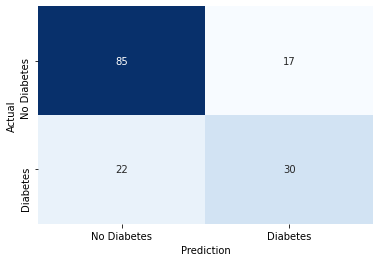

<Figure size 432x288 with 0 Axes>

In [69]:
y_test_pred = model.predict_classes(X_test) # 예측 값을 할당해주고,
c_matrix = confusion_matrix(y_test, y_test_pred) # cm을 행렬로 할당해주고.

ax = sns.heatmap(c_matrix, annot=True, # 그걸로 시각화 해줍니다.
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'],
                cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()
plt.clf()

In [76]:
print(accuracy_score(y_test, y_test_pred))
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))

0.7467532467532467
0.6382978723404256
0.5769230769230769
0.6060606060606061


### 2.9.3 ROC Curve

ROC curve와 AUC도 이미 알고 있으니 수치만 확인하겠다.

In [77]:
from sklearn.metrics import roc_curve, roc_auc_score

In [78]:
# predict() 함수를 사용해 각 클래스의 확률 예측값을 계산한다.

y_test_pred_probs = model.predict(X_test)

In [79]:
# roc_curve 함수를 호출해 roc곡선에 필요한 FPR, TPR을 가져온다.

FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)

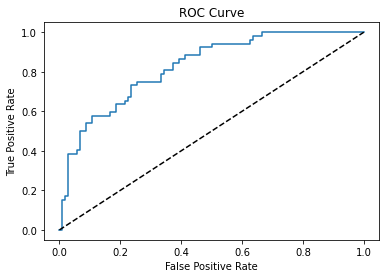

<Figure size 432x288 with 0 Axes>

In [81]:
plt.plot(FPR, TPR)
plt.plot([0,1], [0,1], '--', color='black') # 기준 대각선 그린다.
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
plt.clf()

#### Feature Engineering 을 통한 모델 개선은 생략한다.